In [11]:
# CELL 1: Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from scipy.ndimage import label, center_of_mass
from scipy.stats import pearsonr, ttest_ind

CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
RESULTS_CSV = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results.csv'
OUTPUT_CSV = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results_final.csv'

df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

COPE_MAP_DIFFERENTIAL = {
    'face': (10, 1),
    'word': (13, -1),
    'object': (3, 1),
    'house': (11, 1)
}

COPE_MAP_SCRAMBLE = {
    'face': (10, 1),
    'word': (12, 1),
    'object': (3, 1),
    'house': (11, 1)
}

def create_sphere(center_coord, affine, brain_shape, radius=6):
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - center_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

print("✓ Cell 1 complete")

✓ Cell 1 complete


In [ ]:
# CELL 2: Load Subjects
def load_subjects_by_group(group_filter=None, patient_only=True):
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted([d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], key=int)
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        if not sessions:
            continue
        
        hemisphere = 'l' if row.get('intact_hemi', 'left') == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'surgery_side': row.get('SurgerySide', None)
        }
    return subjects

ALL_PATIENTS = load_subjects_by_group(patient_only=True)
ALL_CONTROLS = load_subjects_by_group(patient_only=False)
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print(f"✓ Loaded {len(ANALYSIS_SUBJECTS)} subjects")
for g in ['OTC', 'nonOTC', 'control']:
    n = sum(1 for v in ANALYSIS_SUBJECTS.values() if v['group'] == g)
    print(f"  {g}: {n}")

✓ Loaded 25 subjects
  OTC: 7
  nonOTC: 9
  control: 9


In [3]:
# CELL 3: EXTRACTION - Top 20% ROI Extraction (Both Contrast Sets)
# ============================================================

def extract_top20_rois(subject_id, cope_map, percentile=80, min_cluster_size=20):
    """Extract ROIs using top 20% of voxels within search mask"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): 
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: 
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): 
                    continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    pos_voxels = z_full[search_mask & (z_full > 0)]
                    
                    if len(pos_voxels) < min_cluster_size: 
                        continue
                    
                    dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                    
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0: 
                        continue
                    
                    # Select largest cluster
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        size = np.sum(labeled == i)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size: 
                        continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': z_full[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'threshold': dynamic_thresh
                    }
                except Exception as e:
                    print(f"Error {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results

# Extract for BOTH contrast sets
print("Extracting Top 20% ROIs - DIFFERENTIAL...")
top20_differential = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_DIFFERENTIAL)
    if res: 
        top20_differential[sub] = res
print(f"✓ Differential: {len(top20_differential)} subjects")

print("\nExtracting Top 20% ROIs - SCRAMBLE...")
top20_scramble = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_SCRAMBLE)
    if res: 
        top20_scramble[sub] = res
print(f"✓ Scramble: {len(top20_scramble)} subjects")

Extracting Top 20% ROIs - DIFFERENTIAL...
✓ Differential: 24 subjects

Extracting Top 20% ROIs - SCRAMBLE...
✓ Scramble: 24 subjects


In [4]:
# CELL 4: SPATIAL RELOCATION (Drift) - Both Contrast Sets
# ============================================================

def compute_spatial_relocation(functional_results, subjects_dict):
    """
    Compute Spatial Relocation (Drift)
    - Euclidean distance between T1 and T2 centroids
    - Higher values = more physical movement
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            c1 = sessions_data[sessions[0]]['centroid']
            c2 = sessions_data[sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(c2) - np.array(c1))
            
            # Flag weak signal (T1 peak z < 2.3)
            t1_z = sessions_data[sessions[0]]['peak_z']
            flag = 'WEAK_SIGNAL' if t1_z < 2.3 else ''
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            results.append({
                'subject': sid,
                'code': info.get('code', sid),
                'group': info.get('group', 'unknown'),
                'hemi': hemi,
                'category': category,
                'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                'spatial_relocation_mm': drift,
                'flag': flag
            })
    
    return pd.DataFrame(results)

# Compute for both contrast sets
print("Computing Spatial Relocation...")
drift_differential = compute_spatial_relocation(top20_differential, ANALYSIS_SUBJECTS)
drift_scramble = compute_spatial_relocation(top20_scramble, ANALYSIS_SUBJECTS)

print(f"\nDIFFERENTIAL Summary:")
print(drift_differential.groupby(['group', 'category_type'])['spatial_relocation_mm'].agg(['mean', 'std', 'count']))

print(f"\nSCRAMBLE Summary (for supplementary):")
print(drift_scramble.groupby(['group', 'category_type'])['spatial_relocation_mm'].agg(['mean', 'std', 'count']))

Computing Spatial Relocation...

DIFFERENTIAL Summary:
                            mean        std  count
group   category_type                             
OTC     Bilateral       6.951114   5.838820     12
        Unilateral     12.486170  12.437719     12
control Bilateral       5.441073   7.067455     36
        Unilateral      5.784939   8.114254     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      5.244716   6.506233     18

SCRAMBLE Summary (for supplementary):
                            mean        std  count
group   category_type                             
OTC     Bilateral       6.951114   5.838820     12
        Unilateral     15.115700  14.963761     12
control Bilateral       5.441073   7.067455     36
        Unilateral      6.628637   7.938228     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      6.820326  11.128870     18


In [5]:
# CELL 5: GEOMETRY PRESERVATION - RDM Stability (6mm, 8mm, 10mm spheres)
# ============================================================

def compute_geometry_preservation(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute Geometry Preservation (RDM Stability)
    - Dynamic sphere at each session's centroid
    - Correlation of 4-category RDM between T1 and T2
    - Lower values = more representational change
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # Dynamic spheres at each session's centroid
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in ['face', 'word', 'object', 'house']:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    rdm = 1 - np.corrcoef(patterns)
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) == 2:
                triu_idx = np.triu_indices(4, k=1)
                r, _ = pearsonr(rdms[first_ses][triu_idx], rdms[last_ses][triu_idx])
                
                hemi = roi_key.split('_')[0]
                category = roi_key.split('_')[1]
                
                results.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'),
                    'hemi': hemi,
                    'category': category,
                    'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                    'geometry_preservation': r
                })
    
    return pd.DataFrame(results)

# Compute for 6mm, 8mm, 10mm
print("Computing Geometry Preservation...")
geometry_results = {}
for radius in [6, 8, 10]:
    geometry_results[radius] = compute_geometry_preservation(
        top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius
    )
    print(f"  {radius}mm: {len(geometry_results[radius])} ROIs")
print("✓ Done")

Computing Geometry Preservation...
  6mm: 132 ROIs
  8mm: 132 ROIs
  10mm: 132 ROIs
✓ Done


In [6]:
# CELL 6: ANCHORED STABILITY - Pattern at Fixed T1 Location
# ============================================================

def compute_anchored_stability(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute Anchored Stability
    - Sphere at T1 centroid ONLY (anchored/fixed location)
    - Pattern correlation T1↔T2 at same location
    - Low values in OTC indicate functional region has relocated
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # ANCHORED: sphere at T1 centroid only
            sphere = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            patterns = {}
            for ses in [first_ses, last_ses]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                data = nib.load(cope_file).get_fdata() * mult
                pattern = data[sphere]
                
                if len(pattern) > 0 and np.all(np.isfinite(pattern)):
                    patterns[ses] = pattern
            
            if len(patterns) == 2:
                try:
                    r, _ = pearsonr(patterns[first_ses], patterns[last_ses])
                    
                    hemi = roi_key.split('_')[0]
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'category': category,
                        'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                        'anchored_stability': r
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

# Compute
print("Computing Anchored Stability (6mm)...")
anchored_results = compute_anchored_stability(
    top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius=6
)
print(f"✓ Done: {len(anchored_results)} ROIs")

Computing Anchored Stability (6mm)...
✓ Done: 132 ROIs


In [7]:
# CELL 7: STATISTICS SUMMARY - All Measures
# ============================================================

def print_summary(df, measure_col, measure_name, higher_means_more_change=True):
    """Print summary statistics for a measure"""
    
    direction = "higher=more change" if higher_means_more_change else "lower=more change"
    print(f"\n{measure_name} ({direction})")
    print("-" * 70)
    
    for group in ['OTC', 'nonOTC', 'control']:
        group_data = df[df['group'] == group]
        bil = group_data[group_data['category_type'] == 'Bilateral'][measure_col]
        uni = group_data[group_data['category_type'] == 'Unilateral'][measure_col]
        
        if len(bil) > 1 and len(uni) > 1:
            t, p = ttest_ind(bil, uni)
            gap = bil.mean() - uni.mean()
            
            # Determine if supports hypothesis (bilateral > change in OTC)
            if higher_means_more_change:
                supports = "✓" if (gap > 0 and group == 'OTC' and p < 0.05) else ""
            else:
                supports = "✓" if (gap < 0 and group == 'OTC' and p < 0.05) else ""
            
            print(f"  {group:<8}: Bil={bil.mean():.3f}±{bil.sem():.3f} (n={len(bil)}), "
                  f"Uni={uni.mean():.3f}±{uni.sem():.3f} (n={len(uni)}), "
                  f"Gap={gap:+.3f}, p={p:.4f} {supports}")

print("="*70)
print("RESULTS SUMMARY - All Measures")
print("="*70)

# Spatial Relocation (higher = more movement)
print_summary(drift_differential, 'spatial_relocation_mm', 
              'SPATIAL RELOCATION (mm)', higher_means_more_change=True)

# Geometry Preservation (lower = more change)
print_summary(geometry_results[6], 'geometry_preservation', 
              'GEOMETRY PRESERVATION (6mm)', higher_means_more_change=False)

# Anchored Stability (lower = region moved away from anchor)
print_summary(anchored_results, 'anchored_stability',
              'ANCHORED STABILITY (6mm)', higher_means_more_change=False)

print("\n" + "="*70)
print("NOTE: Selectivity Change (Liu) computed separately - see results.csv")
print("="*70)

RESULTS SUMMARY - All Measures

SPATIAL RELOCATION (mm) (higher=more change)
----------------------------------------------------------------------
  OTC     : Bil=6.951±1.686 (n=12), Uni=12.486±3.590 (n=12), Gap=-5.535, p=0.1768 
  nonOTC  : Bil=3.419±0.533 (n=18), Uni=5.245±1.534 (n=18), Gap=-1.826, p=0.2686 
  control : Bil=5.441±1.178 (n=36), Uni=5.785±1.352 (n=36), Gap=-0.344, p=0.8485 

GEOMETRY PRESERVATION (6mm) (lower=more change)
----------------------------------------------------------------------
  OTC     : Bil=0.424±0.101 (n=12), Uni=0.713±0.057 (n=12), Gap=-0.289, p=0.0205 ✓
  nonOTC  : Bil=0.726±0.061 (n=18), Uni=0.762±0.046 (n=18), Gap=-0.036, p=0.6408 
  control : Bil=0.659±0.060 (n=36), Uni=0.755±0.035 (n=36), Gap=-0.096, p=0.1733 

ANCHORED STABILITY (6mm) (lower=more change)
----------------------------------------------------------------------
  OTC     : Bil=0.563±0.086 (n=12), Uni=0.352±0.128 (n=12), Gap=+0.211, p=0.1858 
  nonOTC  : Bil=0.884±0.016 (n=18), Uni

In [12]:
# CELL 8: MERGE AND SAVE CSV
# ============================================================

# Load original CSV
df = pd.read_csv(RESULTS_CSV)
print(f"Original CSV: {len(df)} rows")

# Rename existing columns to new naming scheme
rename_existing = {
    'Liu_Distinctiveness': 'Selectivity_Change',
    'RDM_Stability': 'Geometry_Preservation_old',
    'Hybrid_Stability': 'Anchored_Stability_old',
    'Spatial_Drift_mm': 'Spatial_Relocation_mm_old'
}
df = df.rename(columns={k: v for k, v in rename_existing.items() if k in df.columns})

# Create merge helper function
def get_merge_hemi(row):
    if pd.notna(row.get('nonpt_hemi')):
        return row['nonpt_hemi'].upper()
    elif pd.notna(row.get('Intact_Hemisphere')):
        return str(row['Intact_Hemisphere'])[0].upper()
    return None

df['merge_hemi'] = df.apply(get_merge_hemi, axis=1)

# --- Merge Spatial Relocation ---
drift_df = drift_differential.copy()
drift_df['merge_key'] = drift_df['code'] + '_' + drift_df['hemi'].str.upper() + '_' + drift_df['category'].str.capitalize()
df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']

drift_df = drift_df.rename(columns={'spatial_relocation_mm': 'Spatial_Relocation_mm'})
df = df.merge(drift_df[['merge_key', 'Spatial_Relocation_mm']], on='merge_key', how='left')
df = df.drop(columns=['merge_key'])
print(f"Spatial_Relocation_mm: {df['Spatial_Relocation_mm'].notna().sum()}/{len(df)} values")

# --- Merge Geometry Preservation (6mm, 8mm, 10mm) ---
for radius in [6, 8, 10]:
    geom_df = geometry_results[radius].copy()
    geom_df['merge_key'] = geom_df['code'] + '_' + geom_df['hemi'].str.upper() + '_' + geom_df['category'].str.capitalize()
    df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']
    
    col_name = f'Geometry_Preservation_{radius}mm'
    geom_df = geom_df.rename(columns={'geometry_preservation': col_name})
    
    df = df.merge(geom_df[['merge_key', col_name]], on='merge_key', how='left')
    df = df.drop(columns=['merge_key'])
    print(f"{col_name}: {df[col_name].notna().sum()}/{len(df)} values")

# --- Merge Anchored Stability (6mm) ---
anch_df = anchored_results.copy()
anch_df['merge_key'] = anch_df['code'] + '_' + anch_df['hemi'].str.upper() + '_' + anch_df['category'].str.capitalize()
df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']

anch_df = anch_df.rename(columns={'anchored_stability': 'Anchored_Stability_6mm'})
df = df.merge(anch_df[['merge_key', 'Anchored_Stability_6mm']], on='merge_key', how='left')
df = df.drop(columns=['merge_key', 'merge_hemi'])
print(f"Anchored_Stability_6mm: {df['Anchored_Stability_6mm'].notna().sum()}/{len(df)} values")

# Save
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✓ Saved to: {OUTPUT_CSV}")
print(f"Final shape: {df.shape}")

Original CSV: 132 rows
Spatial_Relocation_mm: 132/132 values
Geometry_Preservation_6mm: 132/132 values
Geometry_Preservation_8mm: 132/132 values
Geometry_Preservation_10mm: 132/132 values
Anchored_Stability_6mm: 132/132 values

✓ Saved to: /user_data/csimmon2/git_repos/long_pt/B_analyses/results_final.csv
Final shape: (132, 20)


In [13]:
# CELL 9: Final summary after clean re-run

print("="*70)
print("FINAL RESULTS SUMMARY (n=6 OTC)")
print("="*70)

df = pd.read_csv(OUTPUT_CSV)

measures = [
    ('Selectivity_Change', 'higher'),
    ('Geometry_Preservation_6mm', 'lower'),
    ('Anchored_Stability_6mm', 'lower'),
    ('Spatial_Relocation_mm', 'higher')
]

for measure, direction in measures:
    print(f"\n{measure} ({direction}=more change)")
    print("-"*50)
    
    for group in ['OTC', 'nonOTC', 'control']:
        grp = df[df['Group'] == group]
        bil = grp[grp['Category_Type'] == 'Bilateral'][measure].dropna()
        uni = grp[grp['Category_Type'] == 'Unilateral'][measure].dropna()
        
        if len(bil) > 1 and len(uni) > 1:
            t, p = ttest_ind(bil, uni)
            sig = '✓' if p < 0.05 else ''
            print(f"  {group:<8}: Bil={bil.mean():.3f}±{bil.sem():.3f} (n={len(bil)}), "
                  f"Uni={uni.mean():.3f}±{uni.sem():.3f} (n={len(uni)}), p={p:.4f} {sig}")

FINAL RESULTS SUMMARY (n=6 OTC)

Selectivity_Change (higher=more change)
--------------------------------------------------
  OTC     : Bil=0.419±0.078 (n=12), Uni=0.144±0.031 (n=12), p=0.0033 ✓
  nonOTC  : Bil=0.140±0.022 (n=18), Uni=0.131±0.032 (n=18), p=0.8314 
  control : Bil=0.259±0.028 (n=36), Uni=0.149±0.022 (n=36), p=0.0031 ✓

Geometry_Preservation_6mm (lower=more change)
--------------------------------------------------
  OTC     : Bil=0.424±0.101 (n=12), Uni=0.713±0.057 (n=12), p=0.0205 ✓
  nonOTC  : Bil=0.726±0.061 (n=18), Uni=0.762±0.046 (n=18), p=0.6408 
  control : Bil=0.659±0.060 (n=36), Uni=0.755±0.035 (n=36), p=0.1733 

Anchored_Stability_6mm (lower=more change)
--------------------------------------------------
  OTC     : Bil=0.563±0.086 (n=12), Uni=0.352±0.128 (n=12), p=0.1858 
  nonOTC  : Bil=0.884±0.016 (n=18), Uni=0.720±0.063 (n=18), p=0.0171 ✓
  control : Bil=0.733±0.032 (n=36), Uni=0.653±0.054 (n=36), p=0.2074 

Spatial_Relocation_mm (higher=more change)
-----

In [14]:
# CELL: Check if OTC008 Word changed spatial relocation

print("OTC008 WORD SPATIAL RELOCATION")
print("="*50)

# Check OTC008 Word value
otc008_word = drift_differential[(drift_differential['code'] == 'OTC008') & 
                                  (drift_differential['category'] == 'word')]
print(f"OTC008 Word drift: {otc008_word['spatial_relocation_mm'].values}")

# Compare with and without
otc_drift = drift_differential[drift_differential['group'] == 'OTC']
otc_uni = otc_drift[otc_drift['category_type'] == 'Unilateral']

print(f"\nOTC Unilateral drift values:")
for _, row in otc_uni.iterrows():
    print(f"  {row['code']} {row['category']}: {row['spatial_relocation_mm']:.2f}mm")

print(f"\nMean with OTC008 Word: {otc_uni['spatial_relocation_mm'].mean():.2f}mm")
print(f"Mean without OTC008 Word: {otc_uni[~((otc_uni['code'] == 'OTC008') & (otc_uni['category'] == 'word'))]['spatial_relocation_mm'].mean():.2f}mm")

OTC008 WORD SPATIAL RELOCATION
OTC008 Word drift: [2.07011483]

OTC Unilateral drift values:
  OTC004 face: 9.49mm
  OTC004 word: 41.40mm
  OTC008 face: 2.35mm
  OTC008 word: 2.07mm
  OTC010 face: 11.03mm
  OTC010 word: 16.08mm
  OTC017 face: 12.81mm
  OTC017 word: 30.73mm
  OTC021 face: 2.60mm
  OTC021 word: 4.82mm
  OTC079 face: 0.98mm
  OTC079 word: 15.48mm

Mean with OTC008 Word: 12.49mm
Mean without OTC008 Word: 13.43mm


Extracted 118 drift vectors
  OTC: 18
  nonOTC: 35
  Control: 65


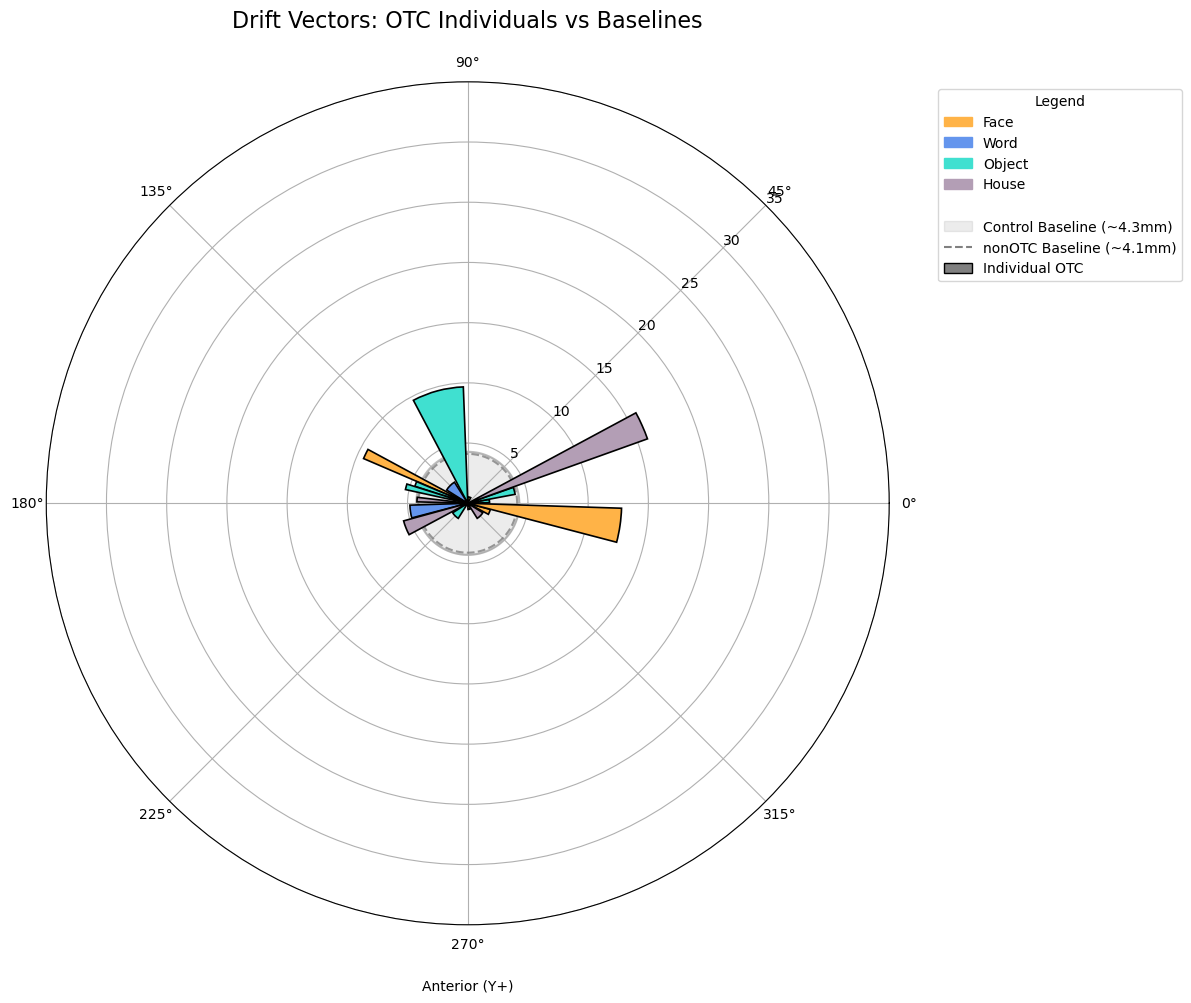

In [17]:
# CELL: Rose Plot (Updated for current pipeline)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- CONFIGURATION ---
BIN_FILL_RATIO = 0.9 

colors = {
    'face': '#FFB347',    # Pastel Peach
    'word': '#6495ED',    # Cornflower Blue
    'object': '#40E0D0',  # Turquoise
    'house': '#B39EB5'    # Pastel Purple
}
categories = ['face', 'word', 'object', 'house']

def cart2pol(y, z):
    return np.arctan2(z, y), np.sqrt(y**2 + z**2)

def get_bin_index(angle, bin_edges, n_bins):
    return min(np.digitize(angle, bin_edges) - 1, n_bins - 1)

def analyze_real_drift(results_dict, subjects_dict):
    data = []
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'control')
        if info.get('patient_status') == 'control': 
            group = 'control'
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: 
                continue
            
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            
            # Use threshold or peak_z for filtering
            t1 = s1.get('threshold', s1.get('peak_z', 0))
            t2 = s2.get('threshold', s2.get('peak_z', 0))
            if t1 < 1.65 or t2 < 1.65: 
                continue
            
            c1 = s1['centroid']
            c2 = s2['centroid']
            dy = c2[1] - c1[1]
            dz = c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            
            data.append({
                'Subject': sid, 'Group': group, 'Category': cat,
                'Radius': radius, 'Angle': angle,
                'Bin_Idx': get_bin_index(angle, bin_edges, N_BINS)
            })
            
    return pd.DataFrame(data)

def plot_dynamic_cluster_rose(df):
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    full_bin_width = (2 * np.pi) / N_BINS
    
    ctrl_mean = df[df['Group'] == 'control']['Radius'].mean()
    nonotc_mean = df[df['Group'] == 'nonOTC']['Radius'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title("Drift Vectors: OTC Individuals vs Baselines", fontsize=16, pad=20)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 35)

    theta = np.linspace(0, 2*np.pi, 100)
    ax.fill_between(theta, 0, ctrl_mean, color='gray', alpha=0.15, zorder=0)
    ax.plot(theta, [ctrl_mean]*100, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)
    ax.plot(theta, [nonotc_mean]*100, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, zorder=2)

    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        items = df[(df['Group'] == 'OTC') & (df['Bin_Idx'] == b_idx)].copy()
        
        if not items.empty:
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            total_usable_width = full_bin_width * BIN_FILL_RATIO
            individual_bar_width = total_usable_width / n_items
            cluster_start = bin_center - (total_usable_width / 2) + (individual_bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                theta = cluster_start + (k * individual_bar_width)
                ax.bar(theta, row['Radius'], width=individual_bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=1.0, edgecolor='black', 
                       linewidth=1.2, zorder=10)

    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in colors.items()]
    style_legend = [
        mpatches.Patch(facecolor='gray', alpha=0.15, edgecolor='gray', label=f'Control Baseline (~{ctrl_mean:.1f}mm)'),
        plt.Line2D([0], [0], color='gray', linestyle='--', label=f'nonOTC Baseline (~{nonotc_mean:.1f}mm)'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='Individual OTC'),
    ]
    ax.legend(handles=legend_cats + [mpatches.Patch(visible=False)] + style_legend, 
              loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    plt.tight_layout()
    #plt.savefig('/user_data/csimmon2/git_repos/long_pt/B_analyses/figures/drift_rose_plot.png', 
    #            dpi=150, bbox_inches='tight')
    plt.show()

# --- EXECUTION ---
df_drift_real = analyze_real_drift(top20_differential, ANALYSIS_SUBJECTS)
print(f"Extracted {len(df_drift_real)} drift vectors")
print(f"  OTC: {len(df_drift_real[df_drift_real['Group'] == 'OTC'])}")
print(f"  nonOTC: {len(df_drift_real[df_drift_real['Group'] == 'nonOTC'])}")
print(f"  Control: {len(df_drift_real[df_drift_real['Group'] == 'control'])}")

plot_dynamic_cluster_rose(df_drift_real)